# Part 1: Measuring the Z boson mass
 This notebook contains basic anlaysis as described in the lab manual.

# Step 0. Importing useful packages

 Most python scripts start with 'import' statements like this that make useful packages available. Examples are 'uproot' which reads in our data files and allows them to be read, 'numpy' is a powerful and popular package for fast manipultation of arrays and 'scipy.stats' is useful for statitical analysis,we'll use it to generate and fit functions to our data.

In [59]:
import lorentz
import uproot3 as uproot
import uproot_methods.classes.TLorentzVector as LVepm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import cauchy
from scipy.stats import norm

import pandas as pd

# Step 1. Access the data file and convert into a 'pandas dataframe'.

 - Here the file is converted into the very poweful 'pandas dataframe' format which is used a lot in modern
     statistical analysis. You can think of the dataframe as a super-charged spreadsheet. Each row represents 
     a proton-proton collision event, and every column represents a piece of information ('observable') we have
     recorded from that event.

 - We are going to work with 7 observables: the components of the muon's four-vector, the charge of the muon and two     extra variables related to how isolated the muon is from other particles. As we will have two muons produced in       each event, that makes 14 observables per event.
 
 
The first thing we want to do is read our data file. Remebmber it contains ~500k proton collision events from the ATLAS Open Data pre-selected so that each event contains two muon candidates with transverse mometum greater than 20000 MeV.

In [60]:
eventsData = uproot.open("data_Skim_mumu.root")["mini"] #this command tells uproot where to find the file
df = eventsData.pandas.df(["muon_E", "muon_pt", "muon_phi", "muon_eta", "muon_charge", "muon_etcone20", "muon_ptcone30"])
print("File has been successfully opened!")

File has been successfully opened!


# NOTE - NONE OF THE REST OF THIS NOTEBOOK WILL RUN UNTIL YOU DOWNLOAD THE INPUT DATA AND SIMULATION FILES FROM HERE. https://drive.google.com/drive/folders/1iqUqc277CDBXsfUks0Z3i9EzhH0C5_Fp?usp=sharing

 - You will need to be logged in to google with your UCT account to gain access
 - PLACE ALL FILES IN THE SAME DIRECTORY AS THIS NOTEBOOK.

We said dataframes are like spreadsheets and we can see that structure directly by simply typing the name of the variable representing the dataframe ("df") into the prompt.
We'll see the familiar row/column structure with our twelve observables and lots of events!

In [61]:
df

,muon_E[0],muon_E[1],muon_pt[0],muon_pt[1],muon_phi[0],muon_phi[1],muon_eta[0],muon_eta[1],muon_charge[0],muon_charge[1],muon_etcone20[0],muon_etcone20[1],muon_ptcone30[0],muon_ptcone30[1]
entry,,,,,,,,,,,,,,
0,59232.882812,55261.050781,49085.519531,39126.156250,0.147713,-2.867906,0.632411,0.879536,1,-1,-991.511536,603.206848,0.000000,0.000000
1,127074.187500,33773.015625,65642.484375,33766.769531,-1.462382,-2.781488,1.279104,-0.018981,-1,1,-788.608521,-1062.793091,1063.258789,0.000000
2,201868.750000,54080.953125,38357.257812,32836.464844,-2.771525,0.050257,-2.344670,-1.083706,-1,1,-320.122009,670.660217,0.000000,0.000000
3,79745.382812,28305.017578,69548.132812,27166.605469,1.549823,-0.946571,-0.535110,0.288473,-1,1,39.919617,-149.053040,0.000000,0.000000
4,28867.724609,98152.656250,27808.724609,25207.083984,-1.008342,1.501000,0.275083,-2.035634,-1,1,121.450531,1119.237671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549252,37704.515625,53827.457031,33141.777344,31681.882812,2.159711,-1.051486,-0.518885,1.122499,-1,1,-380.786377,2450.864258,0.000000,1780.051636
549253,38264.097656,99136.992188,36691.769531,30524.439453,2.490635,-0.590939,0.291705,1.846531,-1,1,188.411438,-137.441544,0.000000,0.000000
549254,39036.566406,114896.968750,36656.058594,28371.234375,0.891378,-2.345073,0.358460,2.076203,-1,1,-491.892853,-164.486343,0.000000,0.000000


You will see each event has values of the variables for "muon[0]" and "muon[1]". These refer to the muon
with the larger and smaller pt values respectively.

The next thing we want to do is apply some more critertia to our data so that it is dominated as much as possible by the Z->mumu process while still retaining as many events as possible.

# Step 2. Apply event selections

In [62]:
#cut0: we require the charges of the muons to be opposite (by requiring the sum to be 0)
cuts0 = df[ ((df["muon_charge[0]"]) + (df["muon_charge[1]"])  == 0)   ]

#cut1: we require the transervse momentum of each muon to be above 20000 MeV'
cuts1 = cuts0[(cuts0["muon_pt[0]"] > 25000) & (cuts0["muon_pt[1]"] > 25000 )]

#cut2: we require the absolute pseudorapidity of each muon to be below 2.4'
cuts2 = cuts1[( np.abs(cuts1["muon_eta[0]"]) < 2.4) & ( np.abs(cuts1["muon_eta[1]"]) < 2.4)]

# cuts 2&3: we require the muons to be isolated from other particles in the event these criteria will be
# explored later in step 7, for now leave them commented out.

cuts3 = cuts2[( (cuts2["muon_etcone20[0]"])/(cuts2["muon_pt[0]"]) < 0.1) & ( (cuts2["muon_etcone20[1]"])/(cuts2["muon_pt[1]"]) < 0.1) ]
cuts4 = cuts3[( (cuts3["muon_ptcone30[0]"])/(cuts3["muon_pt[0]"]) < 0.1) & ( (cuts3["muon_ptcone30[1]"])/(cuts3["muon_pt[1]"]) < 0.1) ]

#we copy out finally selected dataframe to a new variable 'finalData' for convenience
finalData =  cuts4 # you will have to change this line when you want to inlcude the muon 
#isolation criteria, i.e., "finalData =  cuts4" 

#let's check how many events we have selected after all our criteria have been applied
print("Number of selected events = " + str(len(finalData.index)))

# and have a look at our finally selected dataframe
finalData

Number of selected events = 522476


,muon_E[0],muon_E[1],muon_pt[0],muon_pt[1],muon_phi[0],muon_phi[1],muon_eta[0],muon_eta[1],muon_charge[0],muon_charge[1],muon_etcone20[0],muon_etcone20[1],muon_ptcone30[0],muon_ptcone30[1]
entry,,,,,,,,,,,,,,
0,59232.882812,55261.050781,49085.519531,39126.156250,0.147713,-2.867906,0.632411,0.879536,1,-1,-991.511536,603.206848,0.000000,0.000000
1,127074.187500,33773.015625,65642.484375,33766.769531,-1.462382,-2.781488,1.279104,-0.018981,-1,1,-788.608521,-1062.793091,1063.258789,0.000000
2,201868.750000,54080.953125,38357.257812,32836.464844,-2.771525,0.050257,-2.344670,-1.083706,-1,1,-320.122009,670.660217,0.000000,0.000000
3,79745.382812,28305.017578,69548.132812,27166.605469,1.549823,-0.946571,-0.535110,0.288473,-1,1,39.919617,-149.053040,0.000000,0.000000
4,28867.724609,98152.656250,27808.724609,25207.083984,-1.008342,1.501000,0.275083,-2.035634,-1,1,121.450531,1119.237671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549252,37704.515625,53827.457031,33141.777344,31681.882812,2.159711,-1.051486,-0.518885,1.122499,-1,1,-380.786377,2450.864258,0.000000,1780.051636
549253,38264.097656,99136.992188,36691.769531,30524.439453,2.490635,-0.590939,0.291705,1.846531,-1,1,188.411438,-137.441544,0.000000,0.000000
549254,39036.566406,114896.968750,36656.058594,28371.234375,0.891378,-2.345073,0.358460,2.076203,-1,1,-491.892853,-164.486343,0.000000,0.000000


 # Step 3. 'Reconstruct' the Z boson by adding the four-vectors of each muon.

In [63]:
#first we make arrays of four-vectors for the muons. we make separate arrays for muon[0] (leading) and muon[1] (sub-leading)
lvArray0 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[0]"], finalData["muon_eta[0]"], finalData["muon_phi[0]"],finalData["muon_E[0]"])
lvArray1 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[1]"], finalData["muon_eta[1]"], finalData["muon_phi[1]"],finalData["muon_E[1]"])

# the TLorentzVectorArray class conveniently allows us to simply add the array
# to get an array of four-vectors representing the dimuon system in each event
lvArray = lvArray0 + lvArray1
lvArray

<TLorentzVectorArray [TLorentzVector(x=10881, y=-3350.9, z=72178, t=1.1449e+05) TLorentzVector(x=-24498, y=-77156, z=1.0817e+05, t=1.6085e+05) TLorentzVector(x=-2965.6, y=-12223, z=-2.4116e+05, t=2.5595e+05) ... TLorentzVector(x=3195.4, y=8232.8, z=1.2476e+05, t=1.5393e+05) TLorentzVector(x=-1304.6, y=-3035.3, z=-42814, t=1.0089e+05) TLorentzVector(x=-20695, y=822.45, z=-29639, t=96379)] at 0x02188edc8220>

# Step 4.  Make histogram plots of the kinematic information of the muon pairs.

(array([36824., 36645., 32082., 34476., 31244., 35382., 34874., 37769.,
        36047., 36393., 32463., 34237., 32745., 34803., 36222.]),
 array([-3.1400001 , -2.72133327, -2.30266666, -1.88399994, -1.46533334,
        -1.04666662, -0.62800002, -0.20933333,  0.20933333,  0.62800002,
         1.04666662,  1.46533334,  1.88399994,  2.30266666,  2.72133327,
         3.1400001 ]),
 <BarContainer object of 15 artists>)

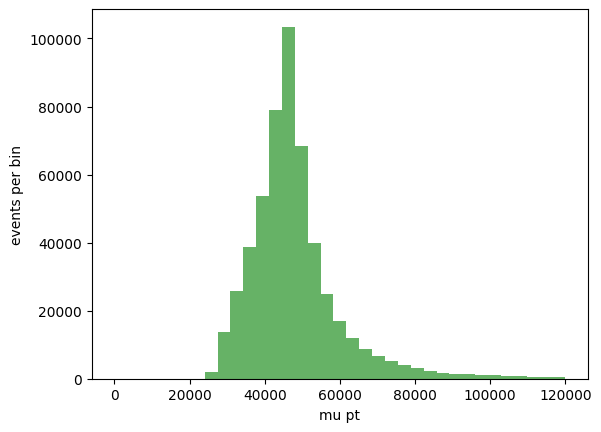

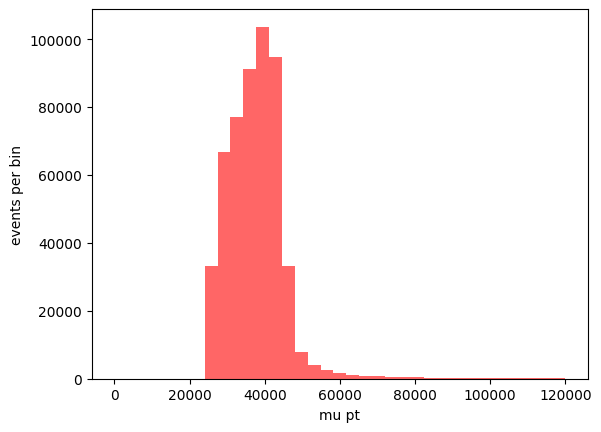

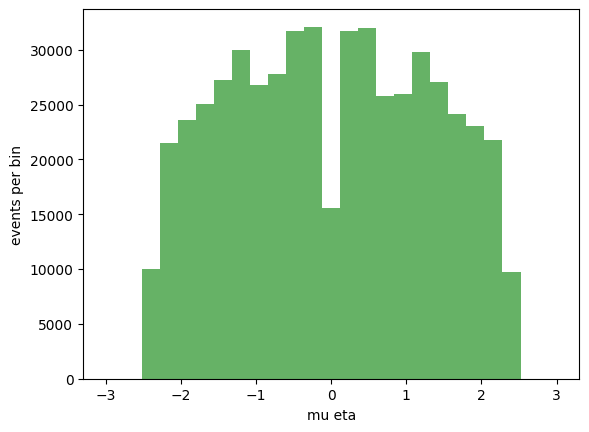

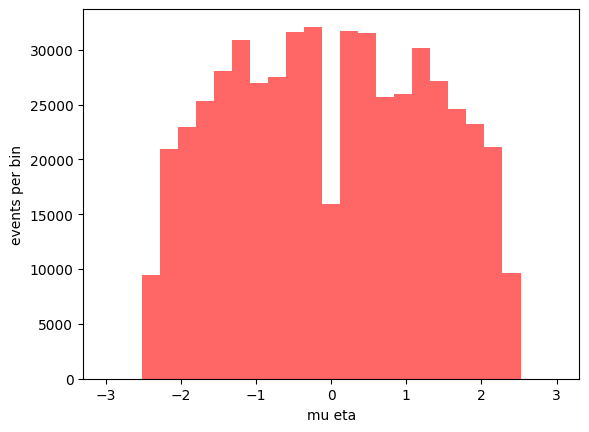

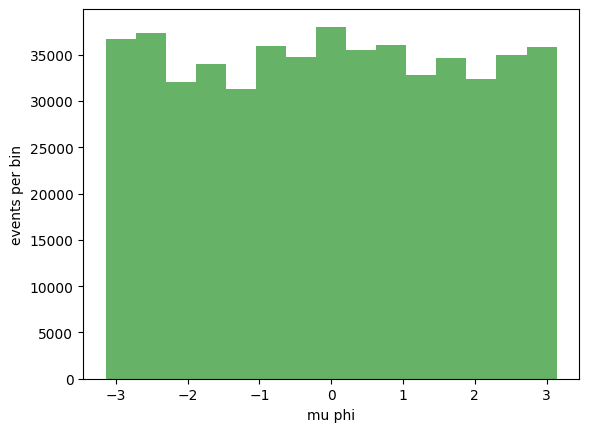

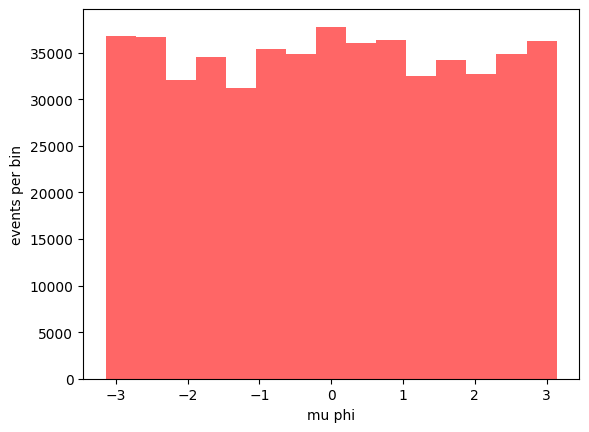

In [64]:
# let's make some simple histograms of the kineamtic information associated with the muons.
# as an example I look at muon[0] only, but you can look at muon[1] and compare the distributions.

# plot the mu[0] pt histogram.
plt.figure()
plt.xlabel("mu pt")
plt.ylabel("events per bin")
plt.hist(lvArray0.pt, bins=35, range=[0,120000], alpha=0.6, color='g')

##
# plot the mu[1] pt histogram.
plt.figure()
plt.xlabel("mu pt")
plt.ylabel("events per bin")
plt.hist(lvArray1.pt, bins=35, range=[0,120000], alpha=0.6, color='r')




# plot the mu[0] pseudorapdity histogram.
plt.figure()
plt.xlabel("mu eta")
plt.ylabel("events per bin")
plt.hist(lvArray0.eta, bins=25, range=[-3.0,3.0], alpha=0.6, color='g')


##
# plot the mu[1] pseudorapdity histogram.
plt.figure()
plt.xlabel("mu eta")
plt.ylabel("events per bin")
plt.hist(lvArray1.eta, bins=25, range=[-3.0,3.0], alpha=0.6, color='r')


# plot the mu[0] phi histogram.
plt.figure()
plt.xlabel("mu phi")
plt.ylabel("events per bin")
plt.hist(lvArray0.phi, bins=15, range=[-3.14,3.14], alpha=0.6, color='g')


##
# plot the mu[1] phi histogram.
plt.figure()
plt.xlabel("mu phi")
plt.ylabel("events per bin")
plt.hist(lvArray1.phi, bins=15, range=[-3.14,3.14], alpha=0.6, color='r')

# Step 5. Make histogram plots of the kinematic information of the muons.
- now that we have reconstructed four-vectors of the dimuon system and know how to make histogram plots,let's make a histogram plot of the dimuon mass distribution and see if the Cauchy distribution can be seen and if the peak is somehwhere around 90 GeV

- we will compare this histogram to a cauchy pdf. However, pdfs are always normalised to an area of 1 while our data represents hundreds of thousands of events, so the data histogram will surely have an integral much larger than 1. Therefore we must first calculate this integral use it to scale our pdf to allow a fair visual comparison between the data histogram and the predicted Cauchy distribution.

In [65]:
#we set up a few parmaters for our histogram, min and max of the x-axis (mass)
minMass = 71000
maxMass = 110000

#the number of bins
nBins = 10

# creating the histogram as two arrays (bin edges & counts in the bins) numpy
countsData, edges = np.histogram(lvArray.mass, bins=nBins, range=(minMass, maxMass))

# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and mult. by bin width, which can be factored out.
# This gives us the integral
integral = bin_width * sum(countsData[0:nBins])

# we can make an array of the centre of each bin directly from the edges array this will be useful in plotting our pdf
centres = (edges[1:] + edges[:-1]) / 2

#fit a Cauchy distributions to the dimuon mass data
mu, std = cauchy.fit(lvArray.mass)
print("mu = " + str(mu))
print("std = " + str(std))
    


mu = 90740.01382209353
std = 2227.6527099609566


So we are almost ready to compare our data histogram with the predicted Cauchy distribution but we know the Cauchy pdf has two free parameters: the mean (mu) and standard deviation (sigma). what should we choose for these values for a first comparison? Why not the world-average values published by the Particle Data group below...

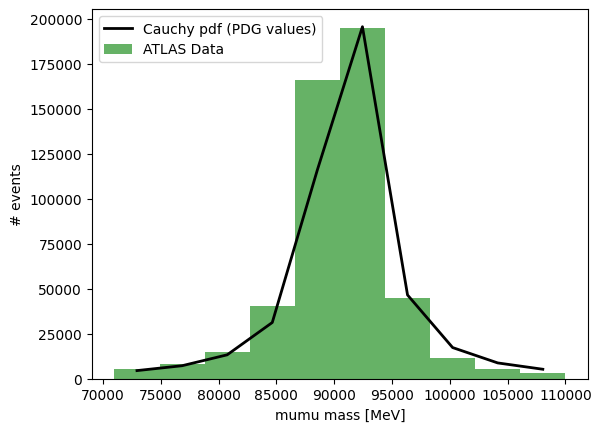

In [66]:
mZPDG  = 91187.6
sigmaZPDG = 2495.2

#let's make the comparison plot
plt.figure()
p = (cauchy.pdf(centres, mZPDG, sigmaZPDG) * integral)
plt.plot(centres, p, 'k',label="Cauchy pdf (PDG values)", linewidth=2)
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass],label="ATLAS Data", alpha=0.6, color='g')
plt.legend()
plt.xlabel("mumu mass [MeV]")
plt.ylabel("# events")
plt.show()



The plot above shows a clear peak and a shape that looks very much like a cauchy distrubtion. So we can be confident that our data conatains the decays of a heavy particle to pairs of muons. However the data does not perfectly agree with the predicted shape of a cauchy distributions with the PDG values for the mass and width of the Z boson.



# 6. Fitting the Cauchy model to the data
In the next part of this notebook we will try to assess if we can find values of the Z mass which result in a better 'agreement' between the data and cauchy model. If we trust the cauchy model completely, then this proceedure is a measurement of the z mass. We'll define the agreement between our data and model with the chi-squared function. the function take in arrays of events counts ('obs') and predictions ('preds') corresponding to the bins of the dimuon mass distribution. the function returns the squared difference between the event count and prediction divded by the variance on the prediction, summed over all bins, otherwise known as the chi-squared function.

In [67]:
#chi-squared function
def calcChiSq(obs, preds):
    chiSq = 0.0
    ndf = len(obs)
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        #print("diff = " + str(diff))
        #var = ( np.abs(obs[bin])) # neymans's chi2 (approximate the of the data's variance as poisson)
        var = ( np.abs(preds[bin])) # pearson's chi2 (approximate the of the prediction's variance as poisson)
        if (var != 0):
            chiSq += (diff**2)/(var)
            #print("obs, pred, diff, var  chi contrib = "+  str( obs[bin]) +" " +  str(preds[bin]) +" "+  str(diff) +" "+  str(var) +" " + str((diff**2)/(var)))
    return chiSq, ndf

To perform the fit we will:
- We'll now loop over a range of $m_{Z}$ values, 
- Generate a cauchy distribution for each value evaluate the $\chi^{2}$ between that distribution and the data histogram.
- find the $m_{Z}$ value that gives the smallest the value of the $\chi^{2}$
- plot the $\Delta \chi^{2}$ vs the $m_{Z}$, and use the \emph{critical values} of this curve to evulated the uncertainties on $m_{Z}$
- compare the data histogram to the fitted} Cauchy distribution

<Figure size 640x480 with 0 Axes>

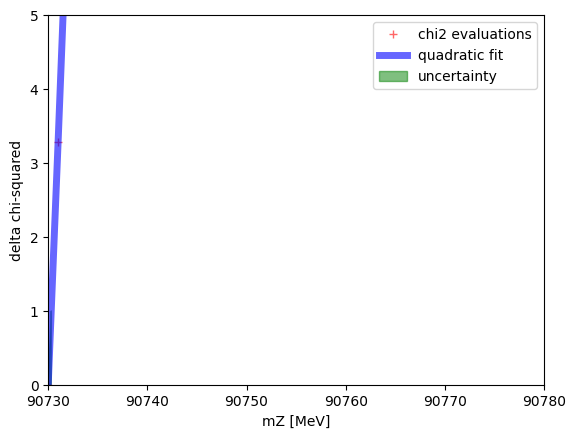

best-fit = 90730 +/- 49.703572007478215


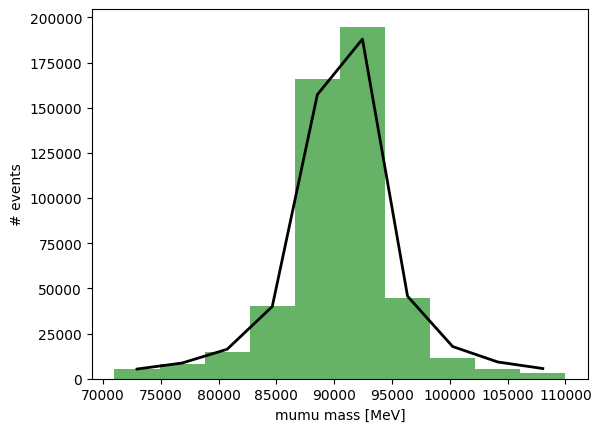

In [68]:
#some arrays to hold the z mass and chi-squared values
mZAr = np.array([])
chi2Ar = np.array([])

#deciding the range of z mass values and how fine the steps in this range will be
minMz = 90730
maxMz = 90780
step = 1

#vairables to use in the loop to find value of z mass that gives smallest chi2
bestFitMz1D = 0.0
minChi2 = 10000000

for mZ in range(minMz, maxMz, step): #starting loop
    countsPDF = (cauchy.pdf(centres, mZ, sigmaZPDG) * integral) #building pdf for these values
    #countsPDF = (norm.pdf(centres, mZ, sigmaZPDG) * integral) #building pdf for these values
    chi2, ndf = calcChiSq(countsData, countsPDF) # call chi2 function to get chi2 for this particular pdf and data
    mZAr = np.append(mZAr, mZ) #adding values to arrays
    chi2Ar = np.append(chi2Ar, chi2)
    if(chi2 < minChi2): #keeping track of what is the smallest chi2 value we have found
        minChi2 = chi2
        bestFitMz1D = mZ
                
# as we will only be interested in the change in chi2 w.r.t. mZ,  we can rescale all the chi2
#values such that the minimum chi2 value is 0. 
chi2Ar = chi2Ar - minChi2

#we expect the chi2 vs. mZ curve to be quadratic, so let's fit that fucntion to it.
z = np.polyfit(mZAr, chi2Ar, 2) #"2" for a second-order polynomial
p = np.poly1d(z)

#lets plot our chi2 values vs mz along with the fit
plt.figure()
fig, ax = plt.subplots()
ax.plot(mZAr, chi2Ar, 'r+', lw=5, alpha=0.6, label="chi2 evaluations")
ax.plot(mZAr, p(mZAr), 'b-', lw=5, alpha=0.6, label="quadratic fit")

# we can display the estimated uncertianty on mZ via critical values () of the delta chi-squared curve
y0 = 1.0
crit = (p - y0).roots # roots of the polynominal -1, i.e., the mz values where p = 1 

#shading in the uncertainty band 
px=np.arange(crit[1],crit[0],0.001)
ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")
ax.legend()

#setting reasonable axis ranges and titles
ax.set_xlim(minMz, maxMz)
ax.set_ylim(0.0, 5.0)
plt.xlabel("mZ [MeV]")
plt.ylabel("delta chi-squared")

plt.show()

#print result and uncertainty
my1DResult = bestFitMz1D
my1DUncertainty = bestFitMz1D-crit[1]
print("best-fit = " + str(my1DResult) + " +/- " + str(my1DUncertainty))

# we now compare our data histogram with the cauchy distribution with the mean and standard deviation
# that minimise the chi-squared. This pdf should agree much better than the pdf with the PDG values.

plt.figure()
p = (cauchy.pdf(centres, my1DResult, sigmaZPDG))

pInt = bin_width * sum(p[0:nBins])
scale = integral/pInt
pScaled = (cauchy.pdf(centres, my1DResult, sigmaZPDG) *scale)

plt.plot(centres, pScaled, 'k', linewidth=2)

x = np.linspace(87000, 94000, 1000)
pScaledNorm = (norm.pdf(x, my1DResult, (sigmaZPDG*0.8) )*(0.6*scale))

#plt.plot(x, pScaledNorm, 'r', linewidth=2)

plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass], alpha=0.6, color='g')
plt.xlabel("mumu mass [MeV]")
plt.ylabel("# events")
plt.show() 

# Try a double gaussian with curve_fit

c:\users\celimpilo rhys\desktop\higgs lab\uct3rdyearlabatlasopendata2023\env\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Celimpilo Rhys\AppData\Local\Temp\ipykernel_2740\1706300996.py:35: RuntimeWarning: overflow encountered in long_scalars
  gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
C:\Users\Celimpilo Rhys\AppData\Local\Temp\ipykernel_2740\1706300996.py:36: RuntimeWarning: invalid value encountered in sqrt
  k = 1.5* np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
C:\Users\Celimpilo Rhys\AppData\Local\Temp\ipykernel_2740\1706300996.py:37: RuntimeWarning: overflow encountered in long_scalars
  return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)


90692.57198741433 4112.206247556977


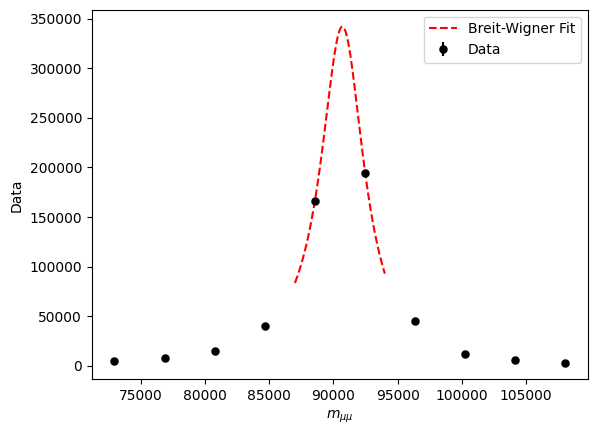

In [69]:
#assume mass, sigma
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def doubleGaussian(x, mean1, amplitude1, standard_deviation1, mean2, amplitude2, standard_deviation2):
    gaus1 = amplitude1 * np.exp( - ((x - mean1) / standard_deviation1) ** 2)
    gaus2 = amplitude2 * np.exp( - ((x - mean2) / standard_deviation2) ** 2)
    return gaus1 + gaus2

#bestFitParams, covarianceMatrix = curve_fit(gaussian, centres, countsData, p0=[91000., 2000., 10000.])
bestFitParams, covarianceMatrix = curve_fit(doubleGaussian, centres, countsData, p0=[91000., 2000., 10000., 91000, 6000, 2000])

###
def doubleexp(x, mean3, amp3, dev3,mean4,amp4,dev4,A,B):
    gauss1 =amp3*np.exp(-((x-mean3)/dev3)**2)
    gauss2= amp4*np.exp(-((x-mean4)/dev3)**2)
    exp =A*np.exp(-B*x)
    return gauss1+gauss2+exp

bestFitFinal, covFinal=curve_fit(doubleexp, centres, countsData, p0=[91000.,2000.,10000.,91000,2000, 10000,1000,1.5e-5])
mean3, amp3, dev3, mean4,amp4, dev4, A, B =bestFitFinal



#plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *bestFitParams), label='gaussian fit')
#plt.plot(x_interval_for_fit, doubleGaussian(x_interval_for_fit, *bestFitParams),'r-', linewidth=3, label='double gaussian fit')
##
#plt.plot(x_interval_for_fit, doubleexp(x_interval_for_fit, *bestFitFinal),'--b', linewidth=3, label='double exponential fit')


##wigner
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 1.5* np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)
popt, pcov = curve_fit(relativistic_breit_wigner,centres, countsData, p0=[91000, 20000, 10000], sigma=np.sqrt(countsData))

x_interval_for_fit=np.linspace(edges[0], edges[-1], 10000)
y = relativistic_breit_wigner(x, *popt)
plt.plot(x, y,'--r', label='Breit-Wigner Fit')
plt.plot()
plt.errorbar(centres, countsData, yerr=np.sqrt(countsData), label="Data", fmt='o', mfc='k', mec='k', mew=0.1, ecolor='k')
plt.legend()
plt.xlabel("$ m_{\mu\mu}$")
plt.ylabel("Data")

print(popt[0], popt[1])


now we have a 'measurement' of mZ, let's make a plot comparing our measured value with that from
the PDG to assess how good our measurement is.

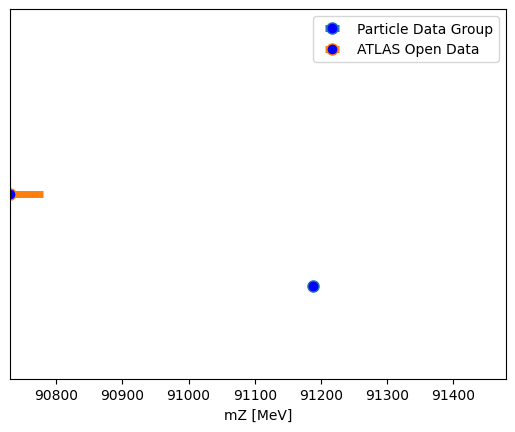

In [70]:
mZPDGAr = np.array([mZPDG]) 
uncZPDGAr = np.array([2.1]) 
yPDGAr = np.array([1.0]) 

mZ1D = np.array([my1DResult]) 
sigZ1D = np.array([my1DUncertainty]) 
y1D = np.array([2.0]) 

plt.figure()
ax = plt.gca()
ax.set_xlim(minMz, maxMz+700)#need to extend x axis range to include PDG value
ax.set_ylim(0.0, 4.0)

plt.errorbar(mZPDGAr, yPDGAr, xerr=uncZPDGAr, label="Particle Data Group", elinewidth=5,  fmt="o", mfc="blue", ms=8)
plt.errorbar(mZ1D, y1D, xerr=sigZ1D, fmt="o", label="ATLAS Open Data", elinewidth=5, ms=8, mfc='blue')

plt.xlabel("mZ [MeV]")
plt.yticks(y1D, " ")


ax.axes.yaxis.set_visible(False)

plt.legend()
plt.show()

Thats completes steps 1-5. You have seen how the chi-squared minisation technique allows us to extract measurements
of a physical parameter such as $m_{Z}$ by comparing the predictions of statistical model to data.

# Now it's your turn!

Refer back to the lab manual to see how you might improve this measurement and have fun!